In [1]:
import numpy as np
import lDGA.config as cfg
import lDGA.dmft_reader as dmft_reader
import lDGA.bse as bse
import lDGA.utilities as util
import matplotlib.pyplot as plt

Running cmake --build & --install in /Users/eminmoghadas/Documents/phd/DGA/build


### load dmft data

In [2]:
# example file
dmft_file = "b53_u2_4_2part-2022-11-19-Sat-07-10-47.hdf5"

dga_cfg = cfg.DGA_Config(dmft_file)
reader = dmft_reader.DMFT_Reader(dga_cfg)

beta = dga_cfg.dmft_dict['beta']
mu = dga_cfg.dmft_dict['mu']
g = dga_cfg.dmft_dict['giw']
s = dga_cfg.dmft_dict['siw']
g2 = dga_cfg.dmft_dict['chi_ph']
niwf = dga_cfg.niwf
n4iwf = dga_cfg.n4iwf
n4iwb = dga_cfg.n4iwb
iw = 0
iw_idx = iw + n4iwb
kdim = dga_cfg.kdim
nk = dga_cfg.nk
q = [0,0]

### calculate lattice chi_q

In [3]:
import time

chi0_w = bse.chi0_loc_w(beta, g, n4iwf, n4iwb)

chi0_q_w = bse.chi0_q_w(beta, mu, g, s, kdim, 96, niwf, n4iwf, n4iwb)

-1.0


/Users/eminmoghadas/anaconda3/envs/dga_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/eminmoghadas/anaconda3/envs/dga_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


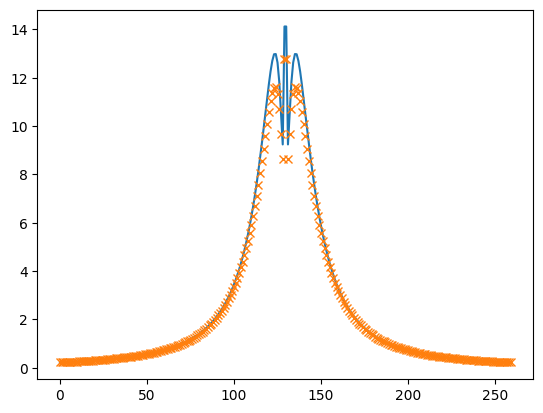

In [6]:
qidx = util.k2ik([0,0],96)
print(bse.ek_2d(kpoints=96).flatten()[qidx])

import correl.w2dyn_post as w5
data = w5.read(dmft_file)
chi0q = data.bubble_q(w5.ek(), w5.ek())

plt.plot(chi0_q_w[:,5,qidx])
plt.plot(chi0q, "x")

In [10]:
st = time.perf_counter()
data = bse.chi_v_r_q_w(beta, 2.4, chi0_w, chi0_q_w, g2, niwf, n4iwf, n4iwb, qpoints=np.array(100*[[0.,0.]]), nk=48)
en = time.perf_counter()

en-st

23.098129334000078

/Users/eminmoghadas/anaconda3/envs/dga_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/eminmoghadas/anaconda3/envs/dga_dev/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


array([0.35849877-7.8429974e-11j])

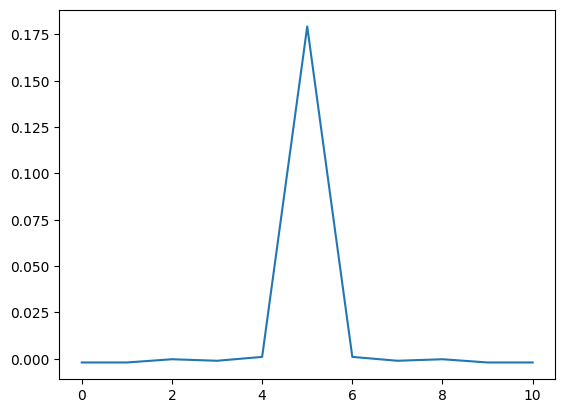

In [7]:
import matplotlib.pyplot as plt


chi = data[0] + w5.asymp_chi(260,53)

plt.plot(chi)

chi[5]*2


In [10]:
dat = w5.read(dmft_file)
chi = dat.bse_ph(w5.ek(), w5.ek(), "c")
chi0 = dat.bubble_q(w5.ek(), w5.ek())
gamma = np.sum((np.diag(1/chi0)@chi),axis=1)/(1-2.4*np.sum(chi)/dat.beta**2)

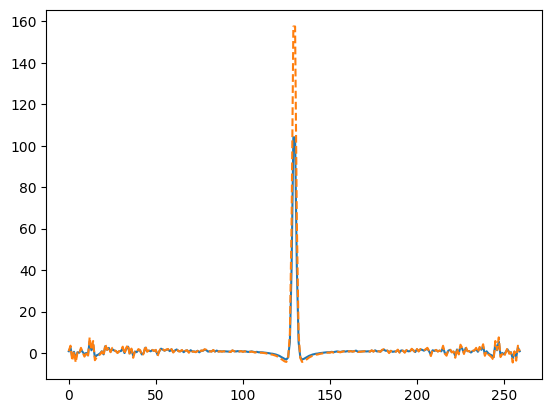

In [13]:
vrq = data[1]

plt.plot(vrq[:,5,0])
plt.plot(gamma, "--")